In [77]:
# Used for -
import numpy as np # Images stored as array values
import pandas as pd # Tabular data
import matplotlib.pyplot as plt # Plotting graphs
from PIL import Image # Helps open and manipulate images
from glob import glob # Find files in directories

from sklearn.model_selection import train_test_split # Splits data into training and testing
from sklearn import metrics # Evaluation

from zipfile import ZipFile # Unzips dataset if zipped
import cv2 # Open CV for image processing and computer vision
import gc # Garbage Collection
import os # File and Folder Operations

import tensorflow as tf # Main deep learning framework
from tensorflow import keras # Used to build neural networks
from keras import layers 

import warnings # ignore unnecessary warnings
warnings.filterwarnings('ignore')

In [78]:
# Dataset Exploration

lung_path = "data/lung_image_set/train"

# List categories inside lung_image_set/train
categories = os.listdir(lung_path)
print("Categories found:", categories)

# Count the amount images in each category
for category in categories:
    # Folder path of each category
    folder = os.path.join(lung_path, category)

    # Glob finds and returns a list of file paths matching the pattern *.jpeg
    images = glob(os.path.join(folder,"*.jpeg"))
    print(f"{category}: {len(images)} images")

Categories found: ['lung_aca', 'lung_n', 'lung_scc']
lung_aca: 5000 images
lung_n: 5000 images
lung_scc: 5000 images


In [79]:
# Load and Preprocess images

IMG_SIZE = 128 # Resize all images to 128x128 pixels
data = [] # Store image arrays
labels = [] # Store numeric labels

# Define categories and assign numeric labels
categories = ['lung_aca', 'lung_n', 'lung_scc']

# loop through each category
for i, category in enumerate(categories):
    # Full path to category folder
    folder = os.path.join(lung_path,category)

    # Get all .jpeg images in this folder
    images = glob(os.path.join(folder,"*.jpeg"))

    # For quick testing
    images = images[:500]

    # loop through all image paths in category
    for image_path in images:
        # Read the image using OpenCV
        img = cv2.imread(image_path)

        # Resize the image to 128x128
        img = cv2.resize(img,(IMG_SIZE, IMG_SIZE))

        # Append the image to the data list
        data.append(img)

        # Append the label(index: i) to labels list
        labels.append(i)

# Convert lists to NumPy arrays

# Normalize pixel to range [0,1]
data = np.array(data) / 255.0 # instead of [255,255,255] = [1,1,1] if white
labels = np.array(labels) # Convert labels to NumPy array

# Print shapes to confirm
print("Data shape:", data.shape) # (15000, 128, 128, 3)
print("Labels shape:", labels.shape)# (15000,)

Data shape: (1500, 128, 128, 3)
Labels shape: (1500,)


In [ ]:
# Split data into training and testing sets

# Split Data: 98.6% Training, 1.4% Testing
# Data = All images, Labels = Shape ID's, 
# test_size = 20% of data for test, random_state = creates reproducible random split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.013, random_state=42)


# Print shapes to confirm
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (1480, 128, 128, 3)
Testing data shape: (20, 128, 128, 3)
Training labels shape: (1480,)
Testing labels shape: (20,)


In [81]:
#Building the CNN Model

#Sequential: Build the model layer by layer in order
from tensorflow.keras import Sequential


# Conv2D: Finds patterns in the image
# MaxPooling2D: Makes the image smaller while keeping important parts
# Flatten: Turns image data into a simle list for next layers
# Dense: Decides between categorization using learned patterns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#Initialize a Sequential model
model = Sequential()

# First Convolutional Layer: 32 filters, 
# 3x3 kernel(3x3 pixels at a time), 
# ReLU activation(Keeps positve values, removes negatives)
# Input_shape = (X,Y,color channels)
model.add(Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)))

# Makes image smaller keeping important info
model.add(MaxPooling2D(pool_size=(2,2)))

# 64 filters convolution layer for deeper patterns
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Turns the 2D image into a 1D list for future layers
model.add(Flatten())

# A normal layer with 128 neurons working with 1D list
model.add(Dense(128, activation='relu'))

# Normal Layer with 3 classes(3 classifications of lung tissue)
# Softmax gives probabilities
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
#Training the CNN Model

# Train the model using training data
# epochs = how many times we go through all training images
# batch_size = how many images we process at once
# validation_data = test data to check accuracy during training

history = model.fit(
    X_train, y_train, 
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.5892 - loss: 1.3628 - val_accuracy: 0.6500 - val_loss: 0.6922
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.7784 - loss: 0.4676 - val_accuracy: 0.8000 - val_loss: 0.4964
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8453 - loss: 0.3615 - val_accuracy: 0.8000 - val_loss: 0.4701
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.8750 - loss: 0.3027 - val_accuracy: 0.7000 - val_loss: 0.4355
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.9034 - loss: 0.2308 - val_accuracy: 0.8500 - val_loss: 0.3514
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9128 - loss: 0.2053 - val_accuracy: 0.9500 - val_loss: 0.2373
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9439 - loss: 0.1619 - val_accuracy: 0.8000 - val_loss: 0.3420
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.9824 - loss: 0.0666 - val_accuracy: 0.

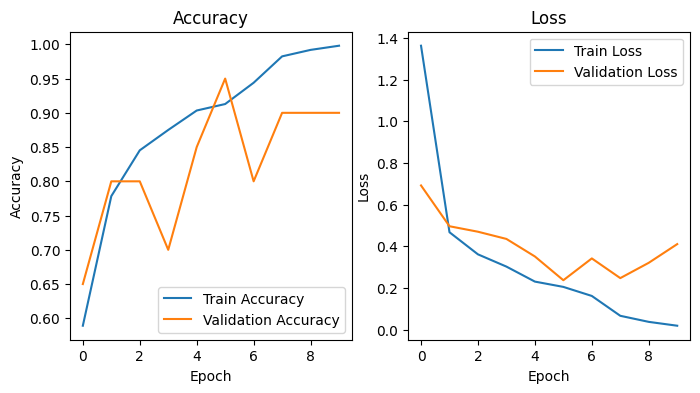

In [83]:
# Visualize the Accuracy and Loss of the Model in a graph

plt.figure(figsize=(8, 4))

# Accuracy plot - Prints the final test accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot - How accuracy improved or decreased over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:

#Evaluate the model on the test set and show predictions

# Evaluate the model on the 1.4% test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Predict on the first 20 images from the test set
predictions = model.predict(X_test[:20])  # Get predictions for 20 images

# Show predicted classes and actual labels
categories = ['lung_aca', 'lung_n', 'lung_scc']  # Class names

tally = 0

print("\nPredictions for first 20 test images:")
for i in range(20):
    predicted_class = np.argmax(predictions[i])  # Class with highest probability
    actual_class = y_test[i]  # True label
    if(actual_class != predicted_class):
        print(f"Incorrect: Image {i+1}: Predicted = {categories[predicted_class]}, Actual = {categories[actual_class]}")
    else:
        print(f"Correct: Image {i+1}: Predicted = {categories[predicted_class]}, Actual = {categories[actual_class]}")
        tally+=1
print(f"{(tally/20) * 100}% Accuracy")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9000 - loss: 0.4107
Test Accuracy: 90.00%
Test Loss: 0.4107
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Predictions for first 5 test images:
Incorrect: Image 1: Predicted = lung_aca, Actual = lung_scc
Correct: Image 2: Predicted = lung_scc, Actual = lung_scc
Correct: Image 3: Predicted = lung_aca, Actual = lung_aca
Correct: Image 4: Predicted = lung_aca, Actual = lung_aca
Correct: Image 5: Predicted = lung_aca, Actual = lung_aca
Correct: Image 6: Predicted = lung_n, Actual = lung_n
Correct: Image 7: Predicted = lung_scc, Actual = lung_scc
Correct: Image 8: Predicted = lung_n, Actual = lung_n
Correct: Image 9: Predicted = lung_scc, Actual = lung_scc
Correct: Image 10: Predicted = lung_aca, Actual = lung_aca
Correct: Image 11: Predicted = lung_n, Actual = lung_n
Incorrect: Image 12: Predicted = lung_aca, Actual = lung_scc
Correct: Image 13: Predicted = lung_n, Actual = lung_n
Correct: Image 14: Predicted = lung_scc, Actual = lung_scc
Correct